In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import FuncFormatter
import matplotlib as mpl

import seaborn as sns
import math
import numpy as np

pd.options.display.max_columns = None

In [107]:
df = pd.read_csv("../Files/merged_trackman_games.csv").copy()

pitch_colors = {'Fastball': 'blueviolet',
                'Sinker': 'magenta', 
                'Cutter': 'crimson', 
                'ChangeUp': 'cyan', 
                'Splitter': 'teal', 
                'Slider': 'lawngreen', 
                'Curveball': 'yellow',
                'Sweeper': 'orange',
                'Knuckleball': '#1BB999',
                'Unknown': 'lightgrey'} 

valid_pitches = {k for k in pitch_colors if k != 'Unknown'}
df['TaggedPitchType'] = df['TaggedPitchType'].apply(lambda x: 'Fastball' if x=='FourSeamFastBall' else x)
df['TaggedPitchType'] = df['TaggedPitchType'].apply(lambda x: 'Unknown' if x not in valid_pitches else x)
df['PlateLocSide'] = df['PlateLocSide']*-1

In [108]:
strike_zone_width = 1.66 # 0.83 + 0.83
strike_zone_height = 2.34 # 3.72 - 1.38
left_of_zone = -strike_zone_width / 2
right_of_zone = strike_zone_width / 2
bottom_of_zone = 1.38
top_of_zone = 3.72
ball_width = (9/np.pi)/12

font_properties = {'family': 'DejaVu Sans', 'size': 12}
font_properties_titles = {'family': 'DejaVu Sans', 'size': 12}
font_properties_axes = {'family': 'DejaVu Sans', 'size': 16}

sns.set_theme(style='whitegrid', palette='deep', font='DejaVu Sans', font_scale=1.5, color_codes=True, rc=None)
mpl.rcParams['figure.dpi'] = 300

In [113]:
df

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,HomeTeamForeignID,AwayTeamForeignID,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence
0,1,2/22/25,05:30.1,1,1,"Seid, Spencer",809262,Left,CSD_TRI,"Dumesnil, Nick",8.250940e+05,Right,CAL_LAN,Undefined,1,Top,0,0,0,Fastball,Four-Seam,BallCalled,Undefined,Undefined,Undefined,0,0,90.64925,0.432719,1.900443,2037.144708,156.551992,11:15,4.87015,-2.27294,5.37321,-16.36367,18.60084,-7.55091,3.91243,1.11980,81.94319,-2.683311,0.559518,0.425584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.33244,9.52567,2.10803,50.0,4.89779,-4.00496,-131.38274,0.48208,7.51301,29.88203,-15.65521,CSD_TRI,CAL_LAN,UCSanDiego,D1,BW,20250222-UCSanDiego-1,a863ac20-f18a-11ef-9456-e7fd19fa9ca5,88.56641,NaN,NaN,8.70606,NaN,NaN,NaN,NaN,NaN,NaN,f92401d5-ad19-4ab4-801b-f579f4bca033,2/23/25,05:30.1,2025-02-22T18:05:30.0717056-08:00,2025-02-23T02:05:30.0717056Z,NaN,v3,NaN,471762.0,NaN,"Gonzalez, Emiliano",1000081438,Right,CSD_TRI,161a4951-5cb1-4e14-bccc-efd6a6b7a50f,55.12203,-132.54258,14.94101,4.86729,1.08972,-7.82761,2.26914,-4.29657,3.75651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN
1,2,2/22/25,05:45.5,1,2,"Seid, Spencer",809262,Left,CSD_TRI,"Dumesnil, Nick",8.250940e+05,Right,CAL_LAN,Undefined,1,Top,0,1,0,Fastball,Sinker,BallCalled,Undefined,Undefined,Undefined,0,0,90.36915,-2.298232,5.488243,1942.903753,126.818131,10:15,4.73413,-2.12090,5.66248,-21.98430,13.10355,-15.85166,0.74802,-1.69154,81.89485,-6.411002,2.672846,0.426334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.78292,7.70910,1.66607,50.0,4.52514,-11.85353,-130.49855,-5.99917,16.72644,29.64637,-18.99334,CSD_TRI,CAL_LAN,UCSanDiego,D1,BW,20250222-UCSanDiego-1,b1b90bd0-f18a-11ef-9456-e7fd19fa9ca5,88.41062,NaN,NaN,8.47431,NaN,NaN,NaN,NaN,NaN,

In [116]:
def plot_pitcher_pitch_heatmap(df: pd.DataFrame, pitcher_name: str, pitch_name: str, ax: plt.axes):
    """
    Plots KDE heatmaps of pitch locations for all pitch types of a single pitcher,
    with a true MLB strike zone and handling missing pitch data.
    """
    df = df[df['Pitcher'] == pitcher_name].reset_index(drop=True).copy()
    sns.kdeplot(data=df[(df['TaggedPitchType'] == pitch_name) & (df['Strikes'] == 2)], x='PlateLocSide', y='PlateLocHeight', cmap='coolwarm', fill=True)
    pitch_count = df[(df['TaggedPitchType'] == pitch_name) & (df['Strikes'] == 2)].shape[0]
    pitch_usage = round((pitch_count / (df[df['Strikes'] == 2]).shape[0]) * 100, 1)

    ## strike zone code
    outer_zone_width = strike_zone_width + 0.48
    outer_zone_height = strike_zone_height + 0.48
    bottom_of_outer_zone = bottom_of_zone - 0.24
    left_of_outer_zone = left_of_zone - 0.24

    strike_zone = patches.Rectangle((left_of_zone, bottom_of_zone), strike_zone_width, strike_zone_height, linewidth=2, edgecolor='black', facecolor='none')
    ax.add_patch(strike_zone)
    
    outer_zone = patches.Rectangle((left_of_outer_zone, bottom_of_outer_zone), outer_zone_width, outer_zone_height, linewidth=1, edgecolor='black', alpha=0.8, facecolor='none')
    ax.add_patch(outer_zone)

    for i in range(1, 3):  
        x = left_of_zone + (i * strike_zone_width / 3)
        ax.plot([x, x], [bottom_of_zone, bottom_of_zone + strike_zone_height], color='gray', linestyle='-')
    for i in range(1, 3):  
        y = bottom_of_zone + (i * strike_zone_height / 3)
        ax.plot([left_of_zone, left_of_zone + strike_zone_width], [y, y], color='gray', linestyle='-')

    ax.grid()
    ax.legend().remove()
    ax.set_xticks(range(-2, 3, 1))
    ax.set_xticklabels(range(-2, 3, 1), fontdict=font_properties)
    ax.set_yticks(range(0, 6, 1))
    ax.set_yticklabels(range(0, 6, 1), fontdict=font_properties)
    x_min, x_max = df['PlateLocSide'].min(), df['PlateLocSide'].max()
    y_min, y_max = df['PlateLocHeight'].min(), df['PlateLocHeight'].max()
    ax.set_xlim(x_min - 1, x_max + 1)
    ax.set_ylim(y_min - 1, y_max + 1)
    ax.set_axis_off()
    ax.set_xlabel('Horiontal Location (ft.)', fontdict=font_properties_axes)
    ax.set_ylabel('Vertical Location (ft.)', fontdict=font_properties_axes)
    pitch_name_cleaned = " ".join(pitcher_name.split(', ')[::-1])
    ax.set_title(f"{pitch_name_cleaned}'s {pitch_name}\n", fontdict=font_properties_titles, loc='left', pad=6)
    ax.text(0.0, 1.02, f"{pitch_count} Pitches ({pitch_usage}%)", transform=ax.transAxes, ha='left', va='bottom', fontsize=10, color='gray')
    ax.set_aspect('equal', adjustable='box')
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


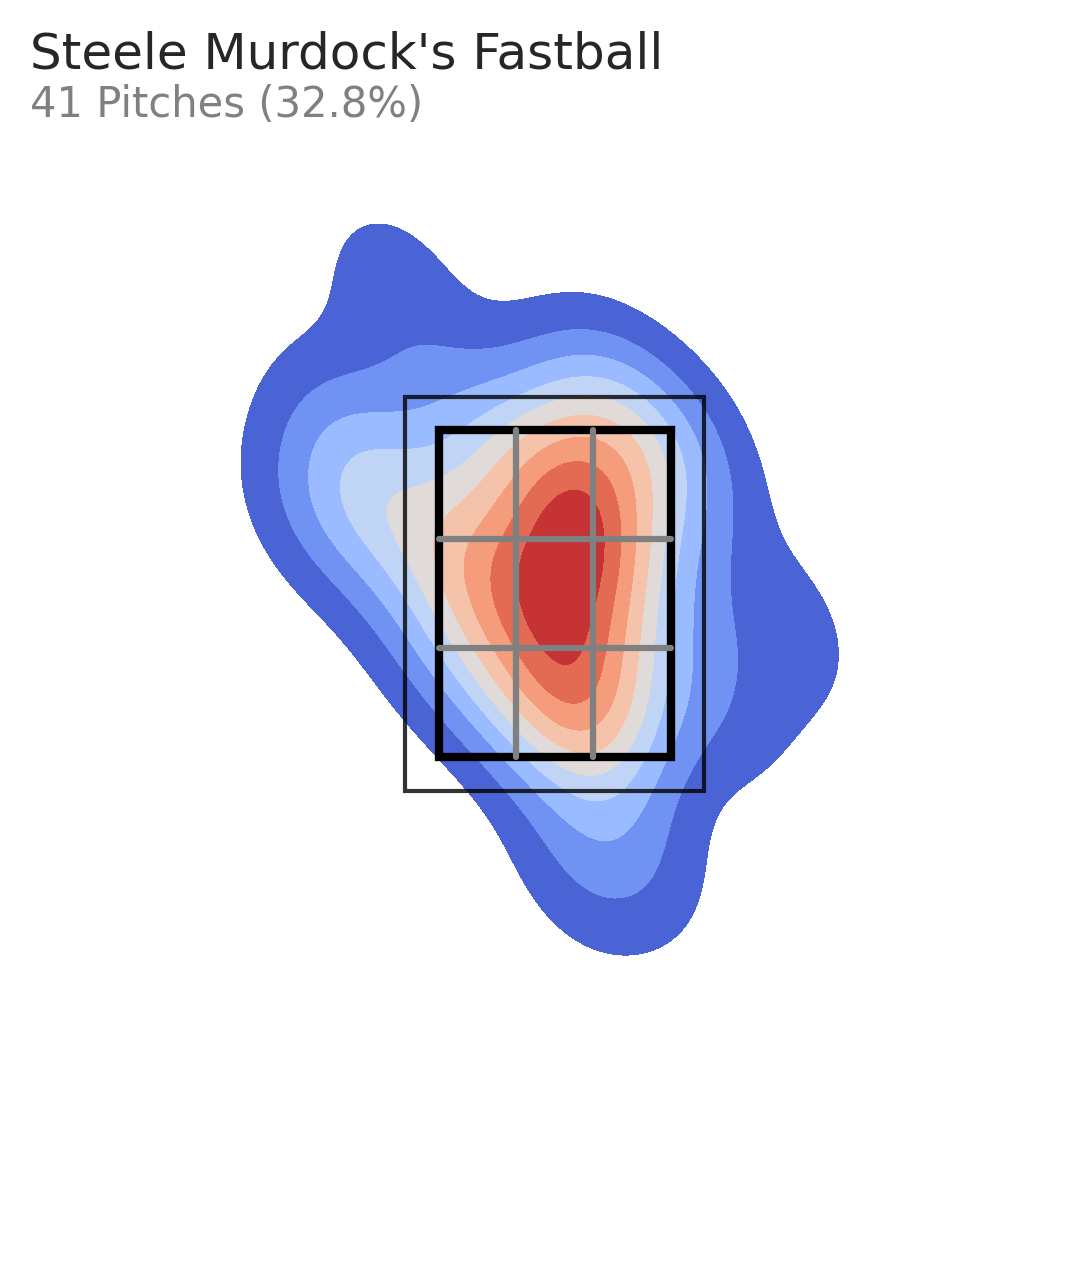

In [120]:
plot_pitcher_pitch_heatmap(df, 'Murdock, Steele', 'Fastball', plt.subplots()[1])

In [126]:
df

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,HomeTeamForeignID,AwayTeamForeignID,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence
0,1,2/22/25,05:30.1,1,1,"Seid, Spencer",809262,Left,CSD_TRI,"Dumesnil, Nick",8.250940e+05,Right,CAL_LAN,Undefined,1,Top,0,0,0,Fastball,Four-Seam,BallCalled,Undefined,Undefined,Undefined,0,0,90.64925,0.432719,1.900443,2037.144708,156.551992,11:15,4.87015,-2.27294,5.37321,-16.36367,18.60084,-7.55091,3.91243,1.11980,81.94319,-2.683311,0.559518,0.425584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.33244,9.52567,2.10803,50.0,4.89779,-4.00496,-131.38274,0.48208,7.51301,29.88203,-15.65521,CSD_TRI,CAL_LAN,UCSanDiego,D1,BW,20250222-UCSanDiego-1,a863ac20-f18a-11ef-9456-e7fd19fa9ca5,88.56641,NaN,NaN,8.70606,NaN,NaN,NaN,NaN,NaN,NaN,f92401d5-ad19-4ab4-801b-f579f4bca033,2/23/25,05:30.1,2025-02-22T18:05:30.0717056-08:00,2025-02-23T02:05:30.0717056Z,NaN,v3,NaN,471762.0,NaN,"Gonzalez, Emiliano",1000081438,Right,CSD_TRI,161a4951-5cb1-4e14-bccc-efd6a6b7a50f,55.12203,-132.54258,14.94101,4.86729,1.08972,-7.82761,2.26914,-4.29657,3.75651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN
1,2,2/22/25,05:45.5,1,2,"Seid, Spencer",809262,Left,CSD_TRI,"Dumesnil, Nick",8.250940e+05,Right,CAL_LAN,Undefined,1,Top,0,1,0,Fastball,Sinker,BallCalled,Undefined,Undefined,Undefined,0,0,90.36915,-2.298232,5.488243,1942.903753,126.818131,10:15,4.73413,-2.12090,5.66248,-21.98430,13.10355,-15.85166,0.74802,-1.69154,81.89485,-6.411002,2.672846,0.426334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.78292,7.70910,1.66607,50.0,4.52514,-11.85353,-130.49855,-5.99917,16.72644,29.64637,-18.99334,CSD_TRI,CAL_LAN,UCSanDiego,D1,BW,20250222-UCSanDiego-1,b1b90bd0-f18a-11ef-9456-e7fd19fa9ca5,88.41062,NaN,NaN,8.47431,NaN,NaN,NaN,NaN,NaN,

In [ ]:
df[df['']]

In [128]:
df[df["Pitcher"] == "Weber, Chapman"].groupby('TaggedPitchType').agg({'RelSpeed': 'max', 'InducedVertBreak': 'max'})

,RelSpeed,InducedVertBreak
TaggedPitchType,,
ChangeUp,85.21744,7.38244
Cutter,80.24114,2.30421
Fastball,92.08434,30.42706
Slider,81.78370,3.79091


In [64]:
pitcher_name = "Weber, Chapman"
pitcher_data = df[df["Pitcher"] == pitcher_name]

# Then you can run your for loop
for i, pitch in enumerate(pitcher_data['TaggedPitchType'].unique().tolist()):
    print(pitch)

Fastball
Slider
Cutter
ChangeUp
